In [1]:
import Pkg; 

In [2]:
using Pkg, DifferentialEquations, PenaltyFunctions, Optim, StatsBase, Plots, CSV, DataFrames, DiffEqParamEstim;

# Exponential growth (individual)

In [26]:
# exponential growth of a single population
#u is the population and p is the parameter
function singleExpGrowth(du,u,p,t)
    du[1] = p[1].*u[1]
end

singleExpGrowth (generic function with 1 method)

In [4]:
# set initial conditions
param = [0.3]
u0 = [12000];
tspan = (0.0, 10.0);

# define ODE problem & solve
prob = ODEProblem(singleExpGrowth,u0,tspan,param);
#sol=solve(prob)
sol = solve(prob); #have one time point per day within the 10 days

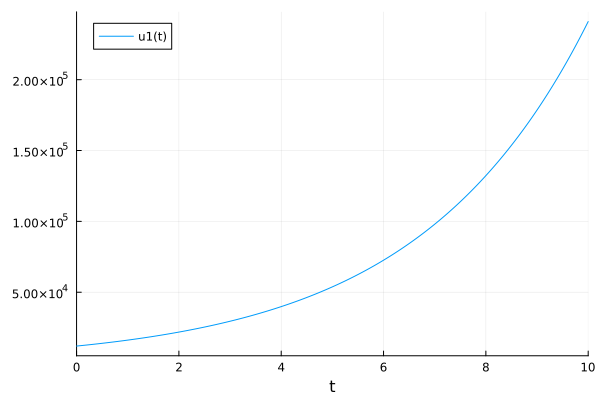

In [5]:
plot(sol)

# Setting up parameter estimation (AIC)

In [6]:
function calcAICscore(RSS,n,k)
    AIC = 2.0*(k+1)+n+log(RSS/n)+n*(1+log(2*pi))
end

calcAICscore (generic function with 1 method)

# Load Data T resistant GFP

In [7]:
#import data
t2="C:\\Users\\adelpinoherrera\\Dropbox (UFL)\\research-share\\Adriana\\Pt-resistant Ovarian Cancer\\Code\\Pop dynamics T cells\\tyk-nucprGFP.csv"
t_r=CSV.read(t2,DataFrame)
data_tr=Matrix(t_r)

3×11 Matrix{Float64}:
 12000.0  13718.1  21778.7  29088.3  57625.8  …       4.23708e5  4.55349e5
 12000.0  18504.3  21978.9  39001.3  44558.6     366332.0        4.97254e5
 12000.0  11294.9  29038.2  34295.1  43056.7          3.35842e5  5.43265e5

In [10]:
timepts = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0];
repli1_tr=data_tr[1,:];
repli2_tr=data_tr[2,:];
repli3_tr=data_tr[3,:];

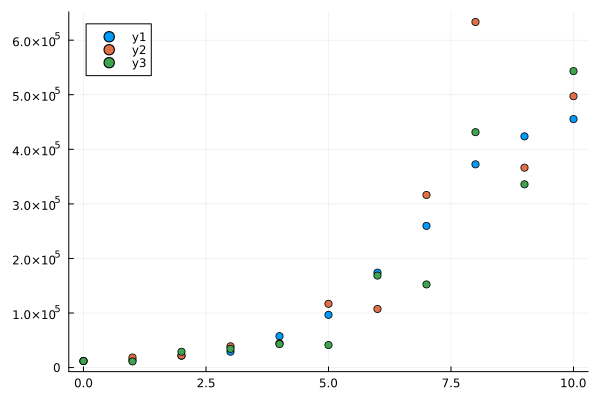

In [11]:
scatter(timepts,repli1_tr)
scatter!(timepts,repli2_tr)
scatter!(timepts, repli3_tr)

# Build Loss Function 

In [12]:
#function to calculate the loss: loss(solve(diffeq), data)
function my_loss_func(sol)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol.u))
      tot_loss = Inf
    else
        # calculation for the loss here
        for i in 1:length(sol.u)#before size(data)[1] #length(sol.u)
            solI = sol.u[i]
            x = data_tr[i,(2:end)]
            y = [solI(1)[1],solI(2)[1],solI(3)[1],solI(4)[1],solI(5)[1],solI(6)[1],solI(7)[1],solI(8)[1],solI(9)[1],solI(10)[1]]
            tot_loss += sum(((x .- y).^2)./((x).^2))
        end
    end
    tot_loss
end   

my_loss_func (generic function with 1 method)

# Build Ensemble Probloem for Solving ODE with Differential Initial Conditions 

In [13]:
# create initial condition array to pull from
N = size(data_tr,1);
initial_conditions = Array{Any}(undef,N,1);
for i=1:N
   initial_conditions[i] = [Float64(data_tr[i,1])];
end

In [14]:
# create function that makes that defines the ODE problem with the different initial conditions pulled from data

function prob_func(prob,i,repeat)
  ODEProblem(prob.f,initial_conditions[i],prob.tspan,prob.p);
end

prob_func (generic function with 1 method)

In [15]:
# build & solve the Ensemble problem 
#     number of trajectories are the number of different initial conditions

monte_prob = EnsembleProblem(prob,prob_func=prob_func);
sim = solve(monte_prob, Rodas5(), EnsembleDistributed(), trajectories = size(initial_conditions)[1]); #saveat=1);

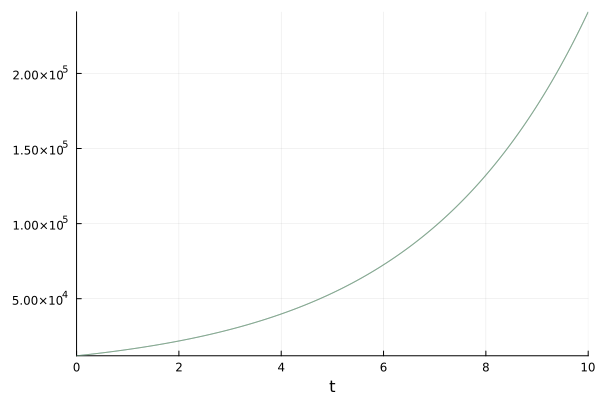

In [16]:
plot(sim,linealpha=0.4)

In [17]:
err = my_loss_func(sim)

5.9631193368989965

# Build Regularized Loss Function 

In [18]:
# Build regularized loss function

prob = ODEProblem(singleExpGrowth,u0,tspan,param);

function build_regularized_loss_func(λ)

    function regularized_loss_func(odeparams) 
        
        function prob_func(prob,i,repeat)
            ODEProblem(prob.f,initial_conditions[i],prob.tspan,odeparams);
        end
        
        monte_prob = EnsembleProblem(prob,prob_func=prob_func);
        
        sim = solve(monte_prob, 
            Rosenbrock23(autodiff=false),
            EnsembleDistributed(), 
            trajectories = size(initial_conditions)[1]
        );
        
        return my_loss_func(sim) + λ*sum(abs.(odeparams));
    end
    
    return regularized_loss_func;
end

build_regularized_loss_func (generic function with 1 method)

# Run Optimization 

In [19]:
result = @time Optim.optimize(build_regularized_loss_func(0),
    [-2.0], [2.0], ## upper and lower bounds 
    param, 
    Fminbox(LBFGS()),
    Optim.Options(f_tol=0.0, g_tol=1e-16, allow_f_increases=true, iterations=100000))

219.843763 seconds (556.22 M allocations: 32.155 GiB, 4.43% gc time, 3.06% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     2.921010e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 8.72e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.33e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.41e-09 ≰ 1.0e-16

 * Work counters
    Seconds run:   215  (vs limit Inf)
    Iterations:    10
    f(x) calls:    189690
    ∇f(x) calls:   189690


In [20]:
paramFIT = result.minimizer

1-element Vector{Float64}:
 0.37393460334257866

In [21]:
paramFitErr = result.minimum     

2.9210097596059397

In [22]:
println("AIC of Exponential Fit: ", calcAICscore(paramFitErr,size(data_tr)[1],1))

AIC of Exponential Fit: 15.48694827514651


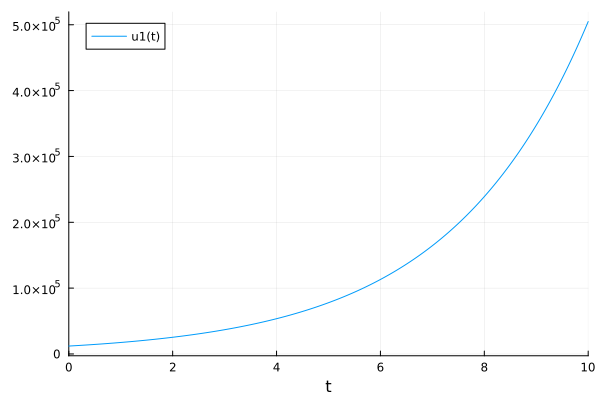

In [23]:
problem = ODEProblem(singleExpGrowth,u0,tspan,paramFIT)
simFit = solve(problem,Vern8());
plot(simFit)

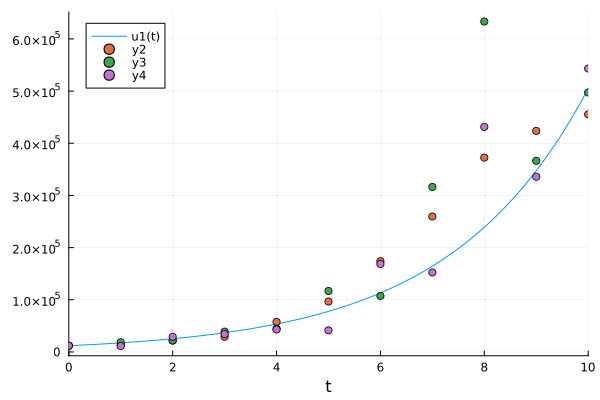

In [24]:
scatter!(timepts,repli1_tr)
scatter!(timepts,repli2_tr)
scatter!(timepts, repli3_tr)

In [25]:
#export estimated curve to csv file
exp_tr = "C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_exp_tr.csv"
CSV.write(exp_tr,simFit)

"C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_exp_tr.csv"

Logistic Growth

In [28]:
# logistic growth of a single population with carrying capacity
function singleLogGrowth(du,u,p,t)
    du[1] = p[1].*u[1].*(1-(u[1]./p[2]))
end

singleLogGrowth (generic function with 1 method)

In [29]:
prob = ODEProblem(singleLogGrowth, u0, tspan, [0.5,500000.0]);

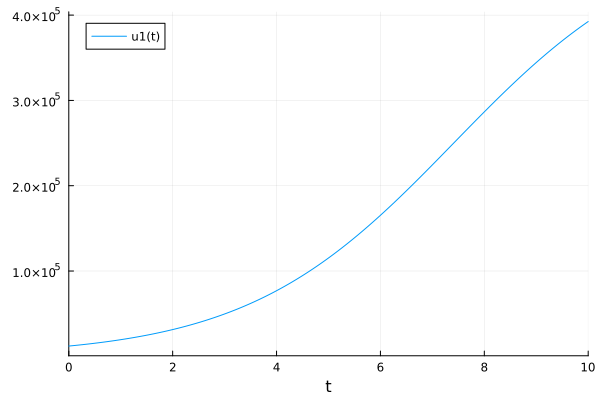

In [30]:
sol = solve(prob); 
plot(sol)

In [31]:
result2 = @time Optim.optimize(build_regularized_loss_func(0),
    [0.0, 2.0], #upper and lower bounds for the optimization variables
    [5.0, 1000000.0], ## bounds on constrains
    [0.01,10.0], #initial values for optimization variables 
    Fminbox(LBFGS()),
    Optim.Options(f_tol=0.0, g_tol=1e-16, allow_f_increases=true, iterations=100000))

355.607595 seconds (1.19 G allocations: 68.975 GiB, 5.19% gc time, 0.16% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     3.472938e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.01e-05 ≰ 1.0e-16

 * Work counters
    Seconds run:   356  (vs limit Inf)
    Iterations:    509
    f(x) calls:    246737
    ∇f(x) calls:   246737


In [32]:
paramFIT2 = result2.minimizer

2-element Vector{Float64}:
      0.3986739762663939
 999999.9999999999

In [33]:
paramFitErr2 = result2.minimum

3.4729378373615374

In [34]:
println("AIC of Logistic Fit: ", calcAICscore(paramFitErr2,size(data_tr)[1],2))

AIC of Logistic Fit: 17.660019785331137


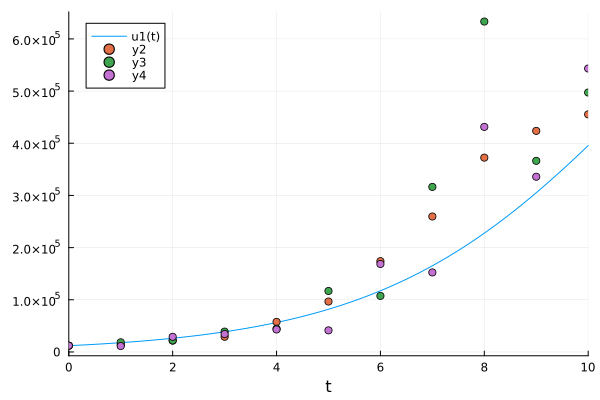

In [35]:
problem2 = ODEProblem(singleLogGrowth,u0,tspan,paramFIT2)
simFit2 = solve(problem2,Vern8());
plot(simFit2)
scatter!(timepts,repli1_tr)
scatter!(timepts,repli2_tr)
scatter!(timepts, repli3_tr)

In [36]:
#export estimated curve to csv file
log_tr = "C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_log_tr.csv"
CSV.write(log_tr,simFit2)

"C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_log_tr.csv"

Gompertz growth

In [37]:
# gompertz growth of a single population with carrying capacity
function singleGompGrowth(du,u,p,t)
    du[1] = p[1].*log(p[2]./u[1]).*u[1] #Maxi
end

singleGompGrowth (generic function with 1 method)

In [122]:
prob = ODEProblem(singleGompGrowth, u0, tspan, [0.5,100000.0]);

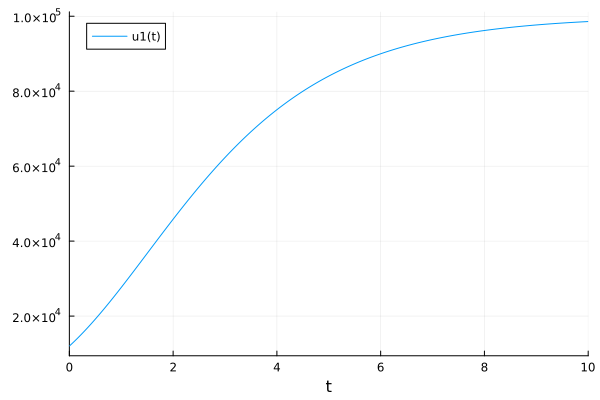

In [123]:
sol = solve(prob); 
plot(sol)

In [58]:
result3 = @time Optim.optimize(build_regularized_loss_func(0),
    [0.0, 2.0], #upper and lower bounds for the optimization variables
    [5.0, 100000000.0], ## bounds on constrains
    [0.01,10.0], #initial values for optimization variables 
    Fminbox(LBFGS()),
    Optim.Options(f_tol=0.0, g_tol=1e-16, allow_f_increases=true, iterations=100000))

  5.237342 seconds (17.92 M allocations: 1.038 GiB, 5.96% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     3.984269e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.76e-04 ≰ 1.0e-16

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    4
    f(x) calls:    3795
    ∇f(x) calls:   3795


In [59]:
paramFIT3 = result3.minimizer

2-element Vector{Float64}:
 0.04807623982948256
 9.999999923718308e7

In [60]:
paramFitErr3 = result3.minimum

3.984269020192105

In [61]:
println("AIC of Logistic Fit: ", calcAICscore(paramFitErr3,size(data_tr)[1],2))

AIC of Logistic Fit: 17.79737277315118


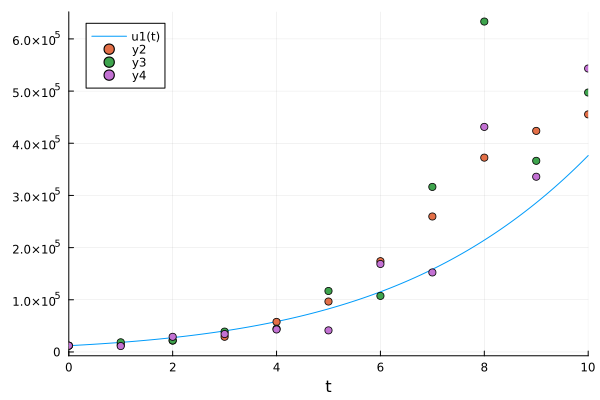

In [62]:
problem3 = ODEProblem(singleGompGrowth,u0,tspan,paramFIT3)
simFit3 = solve(problem3,Vern8());
plot(simFit3)
scatter!(timepts,repli1_tr)
scatter!(timepts,repli2_tr)
scatter!(timepts, repli3_tr)

In [63]:
#export estimated curve to csv file
gomp_tr = "C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_gomp_tr.csv"
CSV.write(gomp_tr,simFit3)

"C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_gomp_tr.csv"

Von Bertalanffy growth

In [64]:
# von bertalanffy growth of a single population assuming sphere
function singleBertGrowth(du,u,p,t)
    du[1] = p[1].*(u[1].^(2/3)) #maxi
    #du[1] = p[1].*(u[1].^(2/3)) - p[2].*u[1]
end

singleBertGrowth (generic function with 1 method)

In [78]:
prob = ODEProblem(singleBertGrowth, u0, tspan, [100]);

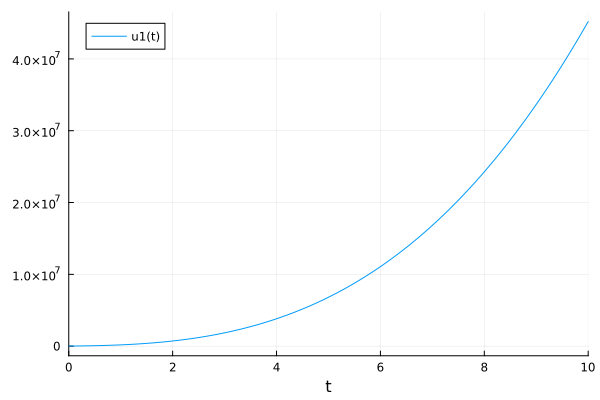

In [79]:
sol = solve(prob); 
plot(sol)

In [77]:
result4 = @time Optim.optimize(build_regularized_loss_func(0),
    [0.0], [100.0],
    param,
    Fminbox(LBFGS()),
    Optim.Options(f_tol=0.0, g_tol=1e-16, allow_f_increases=true, iterations=100000))

 15.717273 seconds (55.64 M allocations: 3.226 GiB, 5.13% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     5.936984e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.33e-08 ≰ 1.0e-16

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    25
    f(x) calls:    20308
    ∇f(x) calls:   20308


In [80]:
paramFIT4 = result4.minimizer

1-element Vector{Float64}:
 11.988918396548037

In [81]:
paramFitErr4 = result4.minimum

5.936983568994339

In [82]:
println("AIC of Logistic Fit: ", calcAICscore(paramFitErr4,size(data_tr)[1],1))

AIC of Logistic Fit: 16.196220098284307


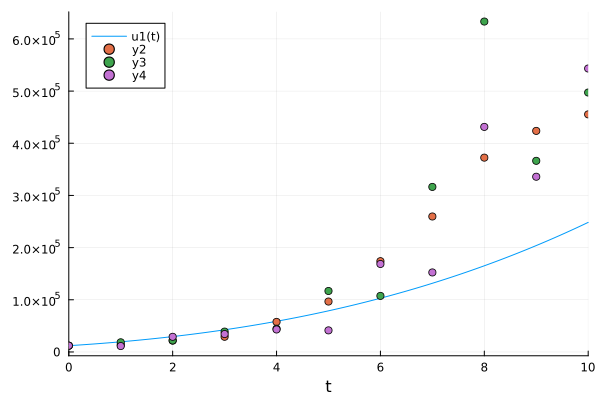

In [83]:
problem4 = ODEProblem(singleBertGrowth,u0,tspan,paramFIT4)
simFit4 = solve(problem4,Vern8());
plot(simFit4)
scatter!(timepts,repli1_tr)
scatter!(timepts,repli2_tr)
scatter!(timepts, repli3_tr)

In [84]:
#export estimated curve to csv file
berta_tr = "C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_berta_tr.csv"
CSV.write(berta_tr,simFit4)

"C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_berta_tr.csv"

Generalized Logistic growth

In [86]:
# generalized logistic growth of a single population with carrying capacity
function singleGenLogGrowth(du,u,p,t)
    du[1] = p[1].*u[1].*(1-(u[1]./p[2]).^p[3])
end

singleGenLogGrowth (generic function with 1 method)

In [87]:
prob = ODEProblem(singleGenLogGrowth, u0, tspan, [0.8,5000000.0,1.5]);

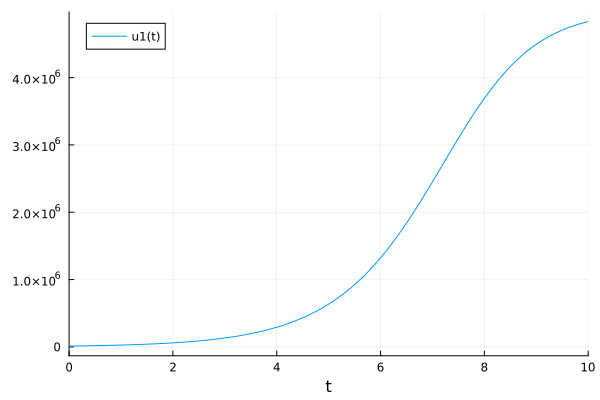

In [88]:
sol = solve(prob); 
plot(sol)

In [96]:
result5 = @time Optim.optimize(build_regularized_loss_func(0),
    [0.0, 2.0, 0.0], #upper and lower bounds for the optimization variables
    [5.0, 100000000.0, 5.0], ## bounds on constrains
    [0.01,10.0, 0.01], #initial values for optimization variables 
    Fminbox(LBFGS()),
    Optim.Options(f_tol=0.0, g_tol=1e-16, allow_f_increases=true, iterations=100000))

179.134012 seconds (598.69 M allocations: 34.643 GiB, 5.23% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     2.921010e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 8.72e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.51e-18 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.33e-07 ≰ 1.0e-16

 * Work counters
    Seconds run:   179  (vs limit Inf)
    Iterations:    17
    f(x) calls:    88584
    ∇f(x) calls:   88584


In [97]:
paramFIT5 = result5.minimizer

3-element Vector{Float64}:
 0.37393460274545104
 5.787679109911513e7
 4.791071699802336

In [98]:
paramFitErr5 = result5.minimum

2.9210097595144333

In [99]:
println("AIC of Logistic Fit: ", calcAICscore(paramFitErr5,size(data_tr)[1],3))

AIC of Logistic Fit: 19.486948275115182


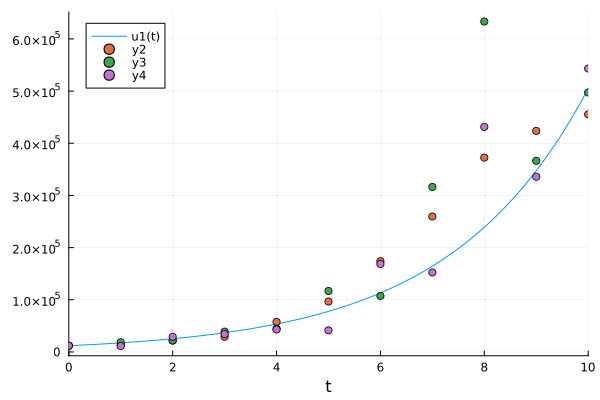

In [100]:
problem5 = ODEProblem(singleGenLogGrowth,u0,tspan,paramFIT5)
simFit5 = solve(problem5,Vern8());
plot(simFit5)
scatter!(timepts,repli1_tr)
scatter!(timepts,repli2_tr)
scatter!(timepts, repli3_tr)

In [101]:
#export estimated curve to csv file
genlog_tr = "C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_genlog_tr.csv"
CSV.write(genlog_tr,simFit5)

"C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_genlog_tr.csv"